# W-14

In [1]:
from FMM_BEM import create_quad_tree_w_msh_file,upward_pass, downward_pass,evaluate_field_at_targets,solve_bem_system
import matplotlib.pyplot as plt
import numpy as np

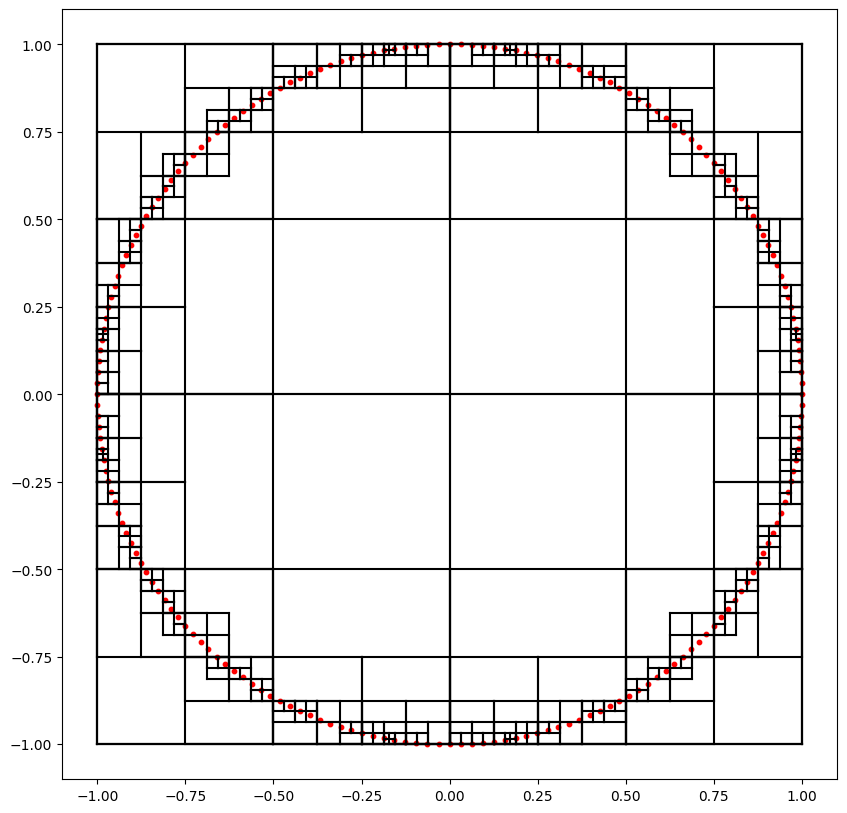

In [2]:
quadtree,boundary_points = create_quad_tree_w_msh_file("files\disk.msh",1,20)

def plot_quadtree(node, ax):
    """ Función recursiva para dibujar los límites del quadtree. """
    xmin, ymin, xmax, ymax = node.bounds
    ax.plot([xmin, xmax], [ymin, ymin], 'k-')
    ax.plot([xmin, xmax], [ymax, ymax], 'k-')
    ax.plot([xmin, xmin], [ymin, ymax], 'k-')
    ax.plot([xmax, xmax], [ymin, ymax], 'k-')

    for child in node.children:
        plot_quadtree(child, ax)

# Visualizar el quadtree
fig, ax = plt.subplots(figsize=(10,10))
plot_quadtree(quadtree, ax)
ax.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', s=10)  # Dibujar los puntos de la frontera
plt.show()

In [2]:
order = 3  # Orden de la expansión multipolar (sujeto a cambios)
upward_pass(quadtree, order=order)

array([ 1.98000000e+02+0.00000000e+00j, -8.30687948e-05-1.16715988e-07j,
       -3.10626877e-10-5.29005499e-16j,  1.76568338e-15-1.07117960e-21j])

In [3]:
downward_pass(quadtree,order=order)

{<quadtree.Quadtree at 0x266e8428c50>: {<quadtree.Quadtree at 0x266e891a8d0>: {<quadtree.Quadtree at 0x266e812d650>: {<quadtree.Quadtree at 0x266fa2ee010>: {<quadtree.Quadtree at 0x266fa2ee250>: {<quadtree.Quadtree at 0x266fa2ee490>: {<quadtree.Quadtree at 0x266fa2ee490>: array([ 2.01532944e+00-1.90756428e-02j, -3.11914657e-02+3.17875795e-02j,
              -9.31427870e-06-9.84047580e-04j,  1.55212790e-05+1.52302078e-05j])},
      <quadtree.Quadtree at 0x266fa2ee510>: {<quadtree.Quadtree at 0x266fa2ee510>: array([ 2.01882874e+00+1.58169083e-02j,  3.12970598e-02+3.17913382e-02j,
              -7.72309976e-06+9.85756220e-04j, -1.55231144e-05+1.52817675e-05j])},
      <quadtree.Quadtree at 0x266fa2ee250>: array([ 2.00005082e+00+0.00053391j,  6.24849035e-02+0.06251827j,
             -1.04278336e-06+0.00390635j, -1.22106001e-04+0.00012204j])},
     <quadtree.Quadtree at 0x266fa2ee010>: array([ 6.99996233e+00+4.20170794e-05j, -4.37500272e-01+4.37495019e-01j,
             3.28258433e-07-5.468

In [4]:
print("Evaluando el campo en los puntos de la frontera...")
field_values = evaluate_field_at_targets(quadtree)

for point, value in field_values.items():
    print(f"Punto: {point}m valoir del campo {value}")

Evaluando el campo en los puntos de la frontera...
Punto: (np.float64(1.0), np.float64(0.0))m valoir del campo 0j
Punto: (np.float64(0.0), np.float64(1.0))m valoir del campo 0j
Punto: (np.float64(-1.0), np.float64(0.0))m valoir del campo (1.9998346328721321+0.03172777768611106j)
Punto: (np.float64(0.0), np.float64(-1.0))m valoir del campo (1.9692477431888653+0.0011027261270757165j)
Punto: (np.float64(0.999506560363376), np.float64(0.03141075915308367))m valoir del campo (3.0342209178800505-0.0026855818954278797j)
Punto: (np.float64(0.9980267284189905), np.float64(0.06279051967683048))m valoir del campo (1.9983983740402824+0.025704173862532154j)
Punto: (np.float64(0.9955619645829901), np.float64(0.09410831353104387))m valoir del campo (2.027288953779397+0.0014042864439864733j)
Punto: (np.float64(0.9921147012781006), np.float64(0.1253332338522595))m valoir del campo (3.007011624901463+0.014483633248354527j)
Punto: (np.float64(0.9876883405353786), np.float64(0.1564344654175354))m valoir d

In [5]:
solve_bem_system(boundary_points=boundary_points,field_values=field_values)

Resolviendo el sistema con GMRES...


(array([-4.65356904e+12-3.69929239e+17j, -4.65356904e+12-3.69929239e+17j,
        -3.81749435e+15-1.28735781e+17j, -1.24121362e+14-1.32424972e+17j,
         3.40089664e+14-3.98221228e+15j, -3.09101788e+15-1.28909045e+17j,
        -1.60092795e+14-1.25424817e+17j, -1.73081779e+15-7.26371444e+15j,
        -1.81399995e+15-1.29979290e+17j,  1.87954468e+15-1.27516478e+17j,
         2.81571782e+13-1.31589245e+17j, -5.62750100e+13-1.25960858e+17j,
         1.47799508e+15-1.29291821e+17j,  6.32942669e+14-1.27393603e+17j,
        -3.04333364e+15+1.11855542e+17j, -2.44467539e+14+1.15124519e+17j,
         2.91662226e+14-1.30897664e+17j, -3.38509211e+14-1.26555523e+17j,
        -1.61735453e+15-1.28376103e+17j, -3.00660490e+14-1.30251389e+17j,
        -7.98110193e+14-9.22508195e+15j, -8.32255045e+14-7.27219616e+15j,
         8.74607947e+14-7.19434329e+15j,  2.02930067e+15-1.26740672e+17j,
         1.87720832e+15-1.30732319e+17j, -2.28476174e+15-1.26897750e+17j,
        -1.79429371e+15-1.30861424e+17